In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import torch
import math
from skimage import filters
from scipy import ndimage
import random
import torch
import nibabel as nb
from glob import glob
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from trainer import run_training 
from unetr import UNETR
from scipy.ndimage import zoom
import torch.nn.functional as F
import math
import torch.nn.init as init
import torch.nn as nn
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss, DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete, Compose
from monai.utils.enums import MetricReduction
from functools import partial
from lr_scheduler import LinearWarmupCosineAnnealingLR
from argparse import Namespace
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
import plotly.express as px 
import csv

In [3]:
args = Namespace(
    checkpoint=None,
    logdir="test",
    pretrained_dir="/home/sarvagya-pc/Desktop/Balgrist_neuroimg/UNETR/pretrained_model/",
    data_dir="/dataset/dataset0/",
    json_list="dataset_0.json",
    pretrained_model_name="UNETR_model_best_acc.pth",
    save_checkpoint=True,  # Set to True if you want to save checkpoints
    max_epochs=500,
    batch_size=1,
    sw_batch_size=1,
    optim_lr=1e-4,
    optim_name="adamw",
    reg_weight=1e-5,
    momentum=0.99,
    noamp=False,  # Set to True if you don't want AMP (Automatic Mixed Precision)
    val_every=10,
    distributed=False,  # Set to True for distributed training
    world_size=1,
    rank=0,
    dist_url="tcp://127.0.0.1:23456",
    dist_backend="nccl",
    workers=8,
    model_name="unetr",
    pos_embed="perceptron",
    norm_name="instance",
    num_heads=12,
    mlp_dim=3072,
    hidden_size=768,
    feature_size=16,
    in_channels=1,
    out_channels=1,
    res_block=False,  # Set to True if using residual blocks
    conv_block=False,  # Set to True if using convolutional blocks
    use_normal_dataset=False,  # Set to True if using MONAI's Dataset class
    a_min=-175.0,
    a_max=250.0,
    b_min=0.0,
    b_max=1.0,
    space_x=1.5,
    space_y=1.5,
    space_z=2.0,
    roi_x=96,
    roi_y=96,
    roi_z=3,
    dropout_rate=0.0,
    RandFlipd_prob=0.2,
    RandRotate90d_prob=0.2,
    RandScaleIntensityd_prob=0.1,
    RandShiftIntensityd_prob=0.1,
    infer_overlap=0.5,
    lrschedule="warmup_cosine",
    warmup_epochs=50,
    resume_ckpt=False,
    resume_jit=False,
    smooth_dr=1e-6,
    smooth_nr=0.0
)

args.amp = not args.noamp

In [4]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

def dice_score_np(y_pred, y_true) -> float:
    # y_pred = y_pred.long()
    # y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class SpinalCordDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        assert len(image_paths) == len(label_paths), "Image and label paths must have the same length"
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load the NIfTI files
        image = nb.load(image_path).get_fdata(dtype=np.float32)  # Shape: (H, W, D)
        label = nb.load(label_path).get_fdata(dtype=np.float32)  # Shape: (H, W, D)

        # Extract specific slices
        image_slices = image[:, :, :20]  # Extract slices 0-19
        label_slices = label[:, :, :20]  # Extract corresponding slices

        # Apply transforms to each slice
        transformed_images = []
        transformed_labels = []

        for i in range(image_slices.shape[2]):
            img_slice = image_slices[:, :, i]
            lbl_slice = label_slices[:, :, i]

            if self.transform:
                img_slice, lbl_slice = self.transform(img_slice, lbl_slice)

            # Convert to PyTorch tensors
            img_tensor = torch.tensor(img_slice, dtype=torch.float32).permute(2, 0, 1)  # Shape: (3, H, W)
            lbl_tensor = torch.tensor(lbl_slice, dtype=torch.float32).unsqueeze(0)      # Shape: (1, H, W)

            transformed_images.append(img_tensor)
            transformed_labels.append(lbl_tensor)

        # Stack slices to form 3D volumes
        transformed_images = torch.stack(transformed_images, dim=3)  # Shape: (20, 3, H, W)
        transformed_labels = torch.stack(transformed_labels, dim=3)  # Shape: (20, 1, H, W)

        

        return {
            "image": transformed_images,
            "label": transformed_labels
        }


In [7]:
class SpinalCordTransform:
    def __init__(self, target_size=(96, 96), flip_prob=0.5):
        self.target_size = target_size
        self.flip_prob = flip_prob

    def resize(self, image, label):
        """
        Resize image and label to the target size.
        """
        zoom_factors_image = (
            self.target_size[0] / image.shape[0],
            self.target_size[1] / image.shape[1]
        )
        zoom_factors_label = (
            self.target_size[0] / label.shape[0],
            self.target_size[1] / label.shape[1]
        )
        resized_image = zoom(image, zoom_factors_image, order=1)  # Bilinear interpolation
        resized_label = zoom(label, zoom_factors_label, order=0)  # Nearest-neighbor interpolation for labels
        return resized_image, resized_label

    def normalize(self, slice_2d):
        """
        Normalize intensity values to [0, 1].
        """
        slice_2d = (slice_2d - np.min(slice_2d)) / (np.max(slice_2d) - np.min(slice_2d) + 1e-8)
        return slice_2d

    def random_flip(self, image, label):
        """
        Randomly flip along spatial axes and ensure contiguous memory.
        """
        if np.random.rand() < self.flip_prob:
            image = np.flip(image, axis=0).copy()
            label = np.flip(label, axis=0).copy()
        if np.random.rand() < self.flip_prob:
            image = np.flip(image, axis=1).copy()
            label = np.flip(label, axis=1).copy()
        return image, label

    def grayscale_to_rgb(self, slice_2d):
        """
        Convert a grayscale slice to RGB by duplicating the grayscale values across three channels.
        """
        return np.stack([slice_2d] * 3, axis=-1)  # Shape: (H, W, 3)

    def __call__(self, image, label):
        """
        Apply all transformations to an image and label.
        """
        # Resize to target size
        image, label = self.resize(image, label)

        # Normalize image
        image = self.normalize(image)
        label = self.normalize(label)

        # Random flips
        image, label = self.random_flip(image, label)

        # Convert image to RGB
        # image = self.grayscale_to_rgb(image)  # Shape: (H, W, 3)
        image = image.reshape(image.shape[0], image.shape[1],1)

        return image, label


In [8]:
# Define the model
model = UNETR(
    in_channels=1,
    out_channels=1,  # Current model output channels
    img_size=(96, 96, 20),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    conv_block=True,
    res_block=True,
    dropout_rate=0.0,
)

# Load the checkpoint
checkpoint = torch.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/UNETR/test/model_final.pt")

# Adjust the output layer weights
state_dict = checkpoint["state_dict"]

# Load the remaining weights into the model
model.load_state_dict(state_dict, strict=False)


# Set model to evaluation mode
model.eval()
model.cuda()

print("Model loaded and output layer reinitialized successfully.")

/tmp/ipykernel_119283/2307933160.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/UNETR/test/model_f

Model loaded and output layer reinitialized successfully.


# THIS IS FOR ALL THE SUBJECTS!!!!

In [9]:
folder = "/media/sarvagya-pc/2TB HDD/Balgrist/GM_mask/for_test/"
subs = sorted(os.listdir(folder))
dice_thresh = [0.8, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
area_each_ses = []
total_area = []
# ids = ids[6:]
# ids.remove("sub-9043")
# to_remove = ['sub-01', 'sub-06','sub-73', 'sub-74', 'sub-75', 'sub-76', 'sub-77']
# for item in to_remove:
#     if item in subs:
#         subs.remove(item)
# subs.pop(0)
# subs.pop(0)
# subs.pop(0)
print(subs)

image_nifti = []
label_nifti = []
for sub in subs:
    sessions = sorted([ses for ses in os.listdir(folder+sub+'/') if "ses-" in ses])
    for ses in sessions:
        file_image = glob(folder+sub+'/'+ses+'/anat/*_acq-lumbarMEGRE3D_desc-crop_T2starw.nii')
        file_label = glob(folder+sub+'/'+ses+'/anat/*_acq-lumbarMEGRE3D_desc-crop_seg-manual_label-SC_mask.nii')
        
        if len(file_label)==0:
            print("this isbject is empty "+sub)
            pass
        else:
            # print(file_image[0])
            # print(file)
            print(file_image[0].split('/')[-1].split("_")[0])
            if file_image[0].split('/')[-1].split("_")[0] != sub:
                print("error with "+sub)
            else:
                image_nifti.append(file_image[0])
                label_nifti.append(file_label[0])
dice_score_final = []
for idx in range(len(image_nifti)):
    dice_score_sub = []
    image_paths_test = [image_nifti[idx]]
    print(image_paths_test)
    label_paths_test = [label_nifti[idx]]

    # Create instances of SpinalCordTransform with desired parameters
    test_transform = SpinalCordTransform(target_size=(96, 96), flip_prob=0.0)
    # test_transform = SpinalCordTransform_test(target_size=(96, 96))

    # Datasets
    test_dataset = SpinalCordDataset(image_paths=image_paths_test, label_paths=label_paths_test, transform=test_transform)

    # DataLoaders
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            if isinstance(batch_data, list):
                data, target = batch_data
            else:
                data, target = batch_data["image"], batch_data["label"]
            data, target = data.cuda(args.rank), target.cuda(args.rank)
            logits = model(data)
            # logits = torch.sigmoid(logits)
    batch = next(iter(test_loader))  # Get a single batch
    images = batch["image"]  # Shape: (batch_size, channels, depth, height, width)
    labels = batch["label"]  # Shape: (batch_size, channels, depth, height, width)
    num_slices = logits.shape[-1]  # Number of slices in the depth dimension
    for i in range(num_slices):
        # plt.figure(figsize=(5, 5))
        # plt.imshow(np.rot90(images[0, 0, :, :, i].cpu().numpy()), cmap="gray", alpha=0.8)
        x = logits[0, 0, :, :, i].cpu().numpy()
        # x = (x>0.5)*1
        x = (x>dice_thresh[i])*1
        area_x = 0.25*np.sum(np.ndarray.flatten(x))
        print(type(labels[0,0,:,:,i]))
        print(type(x))
        score = dice_score(labels[0,0,:,:,i], torch.tensor(x))
        print(score)
        area_each_ses.append(area_x)
        if np.isnan(score):
            score = 1
            dice_score_sub.append(score)
        else:
            dice_score_sub.append(score)
    dice_score_final.append(dice_score_sub)
    total_area.append(area_each_ses)
    dice_score_sub = []
    area_each_ses = []
        # plt.imshow(np.rot90(x), cmap="gray", alpha=0.4)  # Overlay in color
        # plt.title("Image with Overlayed Label")
        # plt.axis("off")
        # plt.show()

['sub-77', 'sub-78', 'sub-79', 'sub-80', 'sub-81', 'sub-82']
sub-77
sub-77
sub-78
sub-79
sub-80
sub-81
sub-82
['/media/sarvagya-pc/2TB HDD/Balgrist/GM_mask/for_test/sub-77/ses-01/anat/sub-77_ses-01_acq-lumbarMEGRE3D_desc-crop_T2starw.nii']
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
nan
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
nan
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.0
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.0
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.0
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.4285714328289032
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.5833333134651184
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.6823529601097107
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.8253968358039856
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.8804348111152649
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.8151260614395142
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
0.8832807540893555
<class 'torch.Tensor'>
<class 'numpy.ndarra

# THIS IS FOR SUBJECT WISE

In [12]:
folder = "/home/sarvagya-pc/Desktop/Balgrist_neuroimg/for_test"
# subs = sorted(os.listdir(folder))
# dice_thresh = [0.8, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

sub = "sub-81"
ses = "ses-01"
# image_npz_test = sorted(glob(folder+'/'+sub+'/'+ses+'/anat/*_acq-lumbarMEGRE3D_desc-crop_T2starw.nii'))
image_npz_test = ["/media/sarvagya-pc/2TB HDD/Balgrist/Segm_extra/Cervical_MEGRE/sub-9024/output_cr.nii"]
label_npz_test = sorted(glob(folder+'/'+sub+'/'+ses+'/anat/*_desc-crop_seg-manual_label-SC_mask.nii'))
print(image_npz_test)
area_each_ses = []
total_area = []

test_transform = SpinalCordTransform(target_size=(96, 96), flip_prob=0.0)
test_dataset = SpinalCordDataset(image_paths=image_npz_test, label_paths=label_npz_test, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

for batch in test_loader:
    images = batch["image"]  # Shape: (batch_size, 20, 3, 96, 96)
    labels = batch["label"]  # Shape: (batch_size, 20, 1, 96, 96)
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

for idx, batch_data in enumerate(test_loader):
    print(idx)

    if isinstance(batch_data, list):
        data, target = batch_data
    else:
        data, target = batch_data["image"], batch_data["label"]
    data, target = data.cuda(), target.cuda()
    print("BEFORE TRANSFORM: ", data.shape)
    # data = data.permute(0, 2, 3, 4, 1)
    # target = target.permute(0, 2, 3, 4, 1)
    # data = data.repeat(1, 3, 1, 1)
    # Calculate the number of channels to add
    channels_to_add = 20 - data.shape[-1]

    # Add zero channels using torch.nn.functional.pad
    padded_tensor = torch.nn.functional.pad(data, (0, channels_to_add))
    print("IN THE MODEL: ", padded_tensor.shape)
    # hr_feats = model_1(data)
    logits = model(padded_tensor)
    print("LOGITS: ", logits.shape)
    print("TARGET: ", target.shape)

['/media/sarvagya-pc/2TB HDD/Balgrist/Segm_extra/Cervical_MEGRE/sub-9024/output_cr.nii']
Image batch shape: torch.Size([1, 1, 96, 96, 16])
Label batch shape: torch.Size([1, 1, 96, 96, 16])
0
BEFORE TRANSFORM:  torch.Size([1, 1, 96, 96, 16])
IN THE MODEL:  torch.Size([1, 1, 96, 96, 20])
LOGITS:  torch.Size([1, 1, 96, 96, 20])
TARGET:  torch.Size([1, 1, 96, 96, 16])


In [9]:
dice_score_final

NameError: name 'dice_score_final' is not defined

In [44]:
len(total_area)

0

In [45]:
# with open("dice_score_my_model.txt", "w") as output:
#     output.write(str(dice_score_final))
# with open('dice_score_my_model_my_own_thresh.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(dice_score_final)

In [46]:
# with open('area_my_model_my_own_thresh.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(total_area)

(120, 120, 16)
(96, 96, 20)
(96, 96, 16)


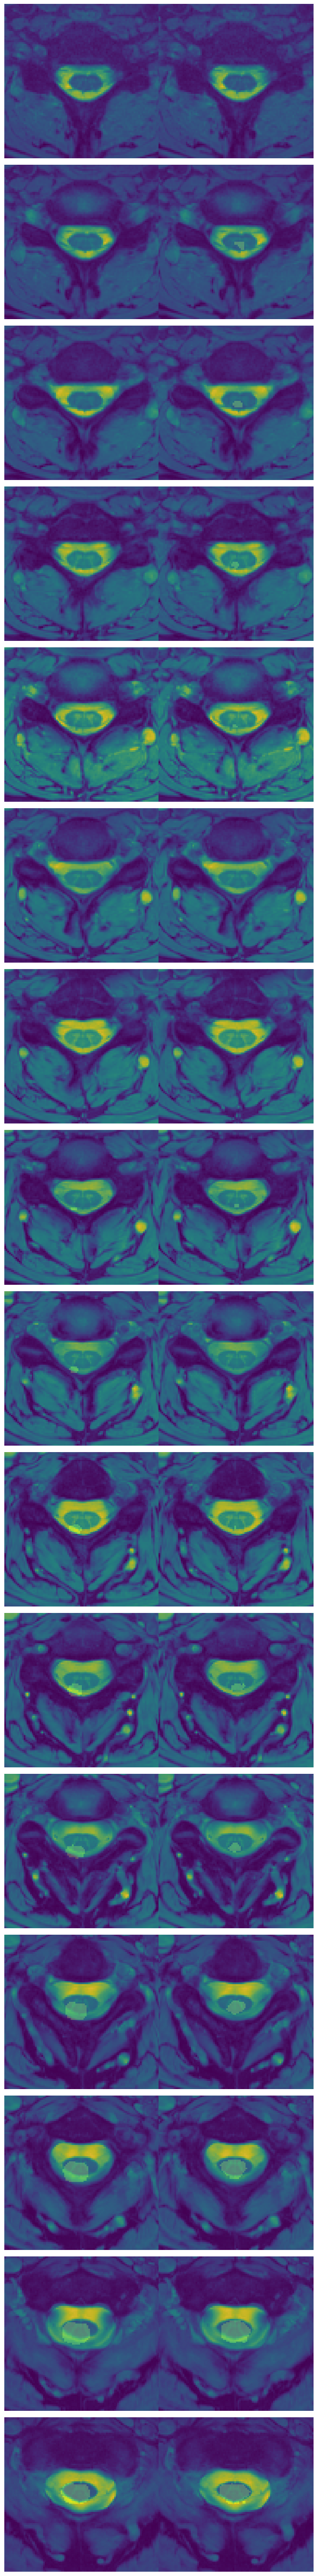

In [15]:
orig_images = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/for_test/"+sub+"/"+ses+"/anat/"+sub+"_"+ses+"_acq-lumbarMEGRE3D_desc-crop_T2starw.nii").get_fdata()
orig_images = nb.load("/media/sarvagya-pc/2TB HDD/Balgrist/Segm_extra/Cervical_MEGRE/sub-9024/output_cr.nii").get_fdata()
print(orig_images.shape)

pred_seg = logits[0,0,:,:,:].detach().cpu().numpy()
print(pred_seg.shape)

orig_seg = labels[0,0,:,:,:].detach().cpu().numpy()
print(orig_seg.shape)

zoom_factors_image = (
    96 / 120,
    96 / 120
)
overlap_alpha = 0.2
num_imgs = 16
fig, axes = plt.subplots(num_imgs, 2, figsize=(8, 60))  # Adjust figsize as needed
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for i in range(num_imgs):
    resized_image = zoom(np.rot90(orig_images[:,:,i], k=1), zoom_factors_image, order=1)
    # Plot image from the first array in the left column
    image_my_pred = np.copy(resized_image)
    image_ground_truth = np.copy(resized_image)


    new_img_pred = (pred_seg[:,:,i]>0.9)*0.9 + image_my_pred*0.1

    axes[i,0].imshow(image_my_pred)
    axes[i,0].imshow(np.rot90(orig_seg[:,:,i], k=1), alpha=overlap_alpha)
    # axes[i,0].imshow(np.rot90(pred_seg[:,:,i]>0.9, k=1), alpha=overlap_alpha)
    # axes[i,0].imshow((pred_seg[:,:,i]>0.6)*1)
    axes[i, 0].axis('off')
    
    # Plot image from the second array in the middle column
    # axes[i, 1].imshow(filters.sobel(orig_seg[i]))
    axes[i,1].imshow(image_ground_truth)
    # axes[i,1].imshow(np.rot90(orig_seg[:,:,i], k=1), alpha=overlap_alpha)
    axes[i,1].imshow(np.rot90(pred_seg[:,:,i]>0.9, k=1), alpha=overlap_alpha)
    axes[i, 1].axis('off')

    # # Plot image from the second array in the right column
    # axes[i, 2].imshow(np.fliplr(np.rot90(orig_images[:,:,i], k=-1)))
    # axes[i, 2].axis('off')

plt.tight_layout()
plt.show()



In [18]:
orig_file_data = nb.load("/media/sarvagya-pc/2TB HDD/Balgrist/Segm_extra/Cervical_MEGRE/sub-9024/output_cr.nii")
seg_array = np.zeros((96,96,16))
# zoom_factors_image = (
#     120 / 96,
#     120 / 96
# )
zoom_factors_image = (
    96 / 120,
    96 / 120
)
for i in range(16):
    # resized_image = zoom(pred_seg[:,:,i]>0.9, zoom_factors_image, order=1)
    # print(resized_image.shape)
    # resized_image = pred_seg[:,:,i]>0.3
    # resized_image = np.fliplr(np.rot90(resized_image, k=-1))
    seg_array[:,:,i] = resized_image

# affine = np.eye(4)
nifti_file = nb.Nifti1Image(seg_array, orig_file_data.affine)
nb.save(nifti_file, "UNETR_output_cervical_affine")

ValueError: could not broadcast input array from shape (77,77) into shape (96,96)